In [3]:
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
%load_ext line_profiler

In [4]:
def calibrate_camera(cal_images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

def camera_setup():
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    nx, ny = 9, 6
    cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist

In [5]:
cam_mtx, cam_dist = camera_setup()

In [6]:
def get_perspective_transform(image, src_in = None, dst_in = None, display=False):
    img_size = image.shape
    if src_in is None:
        src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                        [705. /1280.*img_size[1], 455./720.*img_size[0]],
                        [1130./1280.*img_size[1], 720./720.*img_size[0]],
                        [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    else:
        src = src_in
        
    if dst_in is None:
        dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    else:
        dst = dst_in
        
    warp_m = cv2.getPerspectiveTransform(src, dst)
    warp_minv = cv2.getPerspectiveTransform(dst, src)

    if display:
        plt.subplot(1,2,1)
        plt.hold(True)
        plt.imshow(image, cmap='gray')
        colors = ['r+','g+','b+','w+']
        for i in range(4):
            plt.plot(src[i,0],src[i,1],colors[i])

        im2 = cv2.warpPerspective(image, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        plt.subplot(1,2,2)
        plt.hold(True)
        plt.imshow(im2, cmap='gray')
        for i in range(4):
            plt.plot(dst[i,0],dst[i,1],colors[i])
        plt.show()
    return warp_m, warp_minv

def find_perspective_points(image):
    edges = find_edges(image, True)
    
    # Computing perspective points automatically
    rho = 2              # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 100       # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 # minimum number of pixels making up a line
    max_line_gap = 25    # maximum gap in pixels between connectable line segments

    angle_min_mag = 20*pi/180
    angle_max_mag = 65*pi/180

    lane_markers_x = [[], []]
    lane_markers_y = [[], []]
    
    masked_edges = np.copy(edges)
    masked_edges[:edges.shape[0]*6//10,:] = 0
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = atan2(y1-y2, x2-x1)
            rho = ((x1+x2)*cos(theta) + (y1+y2)*sin(theta))/2
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag):
                if theta > 0: # positive theta is downward in image space?
                    i = 0 # Left lane marker
                else:
                    i = 1 # Right lane marker
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)

    if len(lane_markers_x[0]) < 1 or len(lane_markers_x[1]) < 1:
        # Failed to find two lane markers
        return None
    
    
    p_left  = np.polyfit(lane_markers_y[0], lane_markers_x[0], 1)
    p_right = np.polyfit(lane_markers_y[1], lane_markers_x[1], 1)
    
    # Find intersection of the two lines
    apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
    top_y = ceil(apex_pt[0] + 0.075*edges.shape[0])
    
    bl_pt = ceil(np.polyval(p_left, edges.shape[0]))
    tl_pt = ceil(np.polyval(p_left, top_y))
    
    br_pt = ceil(np.polyval(p_right, edges.shape[0]))
    tr_pt = ceil(np.polyval(p_right, top_y))

    src = np.array([[tl_pt, top_y],
                    [tr_pt, top_y],
                    [br_pt, edges.shape[0]],
                    [bl_pt, edges.shape[0]]], np.float32)

    get_perspective_transform(edges, src_in = src, dst_in = None, display=False) 
    return src

In [7]:
def find_edges(image, ksize = 11, mask_half=False):
    
    blur = cv2.GaussianBlur(image, (ksize, ksize), 0)
    hls = cv2.cvtColor(blur.astype(np.uint8), cv2.COLOR_RGB2HLS)
#     gray = cv2.cvtColor(blur.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = (0.5*blur[:,:,0] + 0.4*blur[:,:,1] + 0.1*blur[:,:,2]).astype(np.uint8)
    s = hls[:,:,2]
    
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 130, 255, cv2.THRESH_BINARY)

    total_px = image.shape[0]*image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
    if cv2.countNonZero(mask_three)/total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask_two = s_binary

    combined_binary = np.clip(cv2.bitwise_and(gray_binary, 
                        cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')

    # Mask out top half of image to reduce distractions
    # Only used when unwarped image is passed in
    if mask_half:
        combined_binary[:ceil(image.shape[0]*0.50)] = 0
#     else:
#         plt.subplot(2, 3, 1)
#         plt.imshow(s_binary, cmap='gray')
#         plt.subplot(2, 3, 2)
#         plt.imshow(mask_three, cmap='gray')
#         plt.subplot(2, 3, 3)
#         plt.imshow((laplacian), cmap='gray')
#         plt.subplot(2, 3, 4)
#         plt.imshow(gray_binary, cmap='gray')
#         plt.subplot(2, 3, 5)
#         plt.imshow(cv2.equalizeHist(s), cmap='gray')
#         plt.subplot(2, 3, 6)
#         plt.imshow(combined_binary, cmap='gray')

    return combined_binary

In [ ]:
image = mpimage.imread('test_images/test1a.jpg')

undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

yellow = (np.array([160, 128, 0]), np.array([255, 255, 128]))
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)

src = find_perspective_points(undist)
warp_m, warp_minv = get_perspective_transform(undist, src, display=True)

img2 = cv2.warpPerspective(undist, warp_m, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
lanes = find_edges(img2)
plt.rcParams['figure.figsize'] = figsize=(10,6)

plt.figure(figsize=(10,12))

plt.subplot(1, 2, 1)
plt.imshow(hls[:,:,2], cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(lanes, cmap='gray')

plt.show()

In [43]:
# Define a class to receive the characteristics of each line detection
import collections
from itertools import chain, repeat
    
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

class Lane():
    def __init__(self, base_pt, img_size, cache_length):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=cache_length)
        self.recent_yfitted = collections.deque(maxlen=cache_length)
        self.weights = np.ones((cache_length,1))
        self.weights[0] = 0.5
        self.weights[1:] = 0.5/(cache_length-1)
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.current_xfit = None
        self.roi_mask = None
        
        self.img_size = img_size
        self.base_pt = base_pt
        
        self.yvals = np.linspace(0, img_size[0], 101)
        self.mask = np.ones(img_size, dtype=np.uint8)*255
        
        self.dropped_frames = 0
    
    def add_lane_pixels(self, x, y):
        # Use all pixels from previous detections for curve fit
        weights = np.ones((len(self.recent_xfitted), 1))
        if len(weights) > 1:
            weights[0] = 0.5
            weights[1:] = 0.5/(len(weights) - 1)

        x_hist = np.fromiter(chain(*(weights*self.recent_xfitted), x), np.int32)
        y_hist = np.fromiter(chain(*(weights*self.recent_yfitted), y), np.int32)
        try:
            p_lane = np.polyfit(y_hist, x_hist, 2)
            rad_curv = self.compute_rad_curv(x_hist, y_hist)
            self.detected = self.sanity_check_lane(rad_curv)
        except Exception as e:
            print(e)
            self.detected = False
            
        if self.detected and len(p_lane) == 3:
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
        
            self.current_xfit = x_fit   # For drawing
        
            # Save current detected pixels
            self.allx = np.array(x)
            self.ally = np.array(y)

            self.recent_xfitted.append(x_fit)
            self.recent_yfitted.append(self.yvals)
            if len(self.current_fit) > 1:
                self.diffs = self.current_fit - p_lane
            
            self.radius_of_curvature = rad_curv
            self.current_fit = p_lane
            self.dropped_frames = 0
        else:
            # Sanity check failed
            # Use last fit if current one failed
            p_lane = self.current_fit
            rad_curv = self.radius_of_curvature
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
            self.dropped_frames += 1
        
#         plt.imshow(image)
#         plt.plot(x_fit, self.yvals)
#         plt.plot(x_hist, y_hist)
        # Update ROI mask
        self.mask.fill(0)
        # http://stackoverflow.com/a/35902430/538379 
        pts = np.transpose(np.vstack([x_fit, self.yvals])).reshape((-1,1,2)).astype(np.int32)
        cv2.drawContours(self.mask, pts, -1, (255,255,255), thickness=80)
        
    @staticmethod
    def compute_rad_curv(xvals, yvals):
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        y_eval = np.max(yvals)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
        
        
    def sanity_check_lane(self, R):
        """
        Checks new radius of curvature `R` against the radius stored in the object.
        """
        # Return true if there is no prior data
        if self.radius_of_curvature is None:
            return True
        
        k = 1/R   # Curvature is a better measure to track
        R0 = self.radius_of_curvature
#         k0 = 1/self.radius_of_curvature
#         return abs(k-k0)/k0 <= 0.05
        return abs(R-R0)/R0 <= 0.10  # Max change from frame to frame is 5%
            
        
    def detect_from_mask(self, image):
        mask_lanes = cv2.bitwise_and(image, self.mask)
        all_pts = cv2.findNonZero(mask_lanes)
        if all_pts is not None:
            all_pts = all_pts.reshape((-1,2))
            self.add_lane_pixels(all_pts[:,0], all_pts[:,1])
        else:
            self.detected = False
        
    def draw_lane(self, image):
        """
        Draws lane on given image
        """
        pts = np.array([np.transpose(np.vstack([self.current_xfit, self.yvals]))])
        cv2.fillPoly(image, np.int_([pts]), (0,255, 0))
        return image
    
def reject_outliers(x_list, y_list):
    if not x_list or not y_list:
        return x_list, y_list
    mu_x, mu_y = np.mean(x_list), np.mean(y_list)
    sig_x, sig_y = np.std(x_list), np.std(y_list)
    new_x, new_y = zip(*[(x, y) for (x,y) in zip(x_list, y_list) 
                                 if abs(x - mu_x) < 2*sig_x and abs(y - mu_y) < 2*sig_y])
    return new_x, new_y

def histogram_lane_detection(image, left_lane, right_lane, base_pts, num_bands = 10, window_width = 0.2):
    """Uses histogram and sliding window to detect lanes from scratch"""

    height = image.shape[0]
    band_height = int(1./num_bands * height)   # Divide image into horizontal bands
    band_width = int(window_width*image.shape[1])
    
    l_x, l_y, r_x, r_y = [], [], [], []
    
    base_left, base_right = base_pts

    idx_left, idx_right = base_pts
    for i in reversed(range(num_bands)):
        w_left = image[i*band_height:(i+1)*band_height,base_left-band_width//2:base_left+band_width//2]
        w_right = image[i*band_height:(i+1)*band_height,base_right-band_width//2:base_right+band_width//2]
        
        left_y_pt, left_x_pt = np.nonzero(w_left)
        right_y_pt, right_x_pt = np.nonzero(w_right)
        
        l_x.extend(left_x_pt + base_left-band_width//2)
        l_y.extend(left_y_pt + i*band_height)
        r_x.extend(right_x_pt+ base_right-band_width//2)
        r_y.extend(right_y_pt+ i*band_height)

        # Find 'x' with maximum nonzero elements as baseline for next window
        s_left = np.sum(w_left, axis=0)
        s_right = np.sum(w_right, axis=0)
        if np.any(s_left > 0):
            base_left = np.argmax(s_left) + base_left-band_width//2
        if np.any(s_right > 0):
            base_right = np.argmax(s_right) + base_right-band_width//2

    l_x, l_y = reject_outliers(l_x, l_y)
    r_x, r_y = reject_outliers(r_x, r_y)
    
    left_lane.add_lane_pixels(l_x, l_y)
    right_lane.add_lane_pixels(r_x, r_y)

    return left_lane, right_lane

In [45]:
from scipy.signal import find_peaks_cwt

def find_base_points(lanes, min_peak = 25.0):
    """Uses histogram to find possible base points for lane lines"""
    hist = np.sum(lanes[int(lanes.shape[0]*0.5):,:], axis=0)

    widths = [100]
    idx = find_peaks_cwt(hist, widths, max_distances=widths, noise_perc=50) 
    if len(idx) < 2:
        return None

    # Avoid edges
    idx = [i for i in idx if i > lanes.shape[1]*0.1 
                             and i < lanes.shape[1]*0.9
                             and max(hist[i-50:i+50]) > min_peak]
#     middle = np.average(idx)
#     left_pt = max(i for i in idx if i < middle)   # Closest peak to middle on the left    
#     right_pt = min(i for i in idx if i >= middle) # Closest peak to middle on the right
    return [min(idx), max(idx)]

CPU times: user 618 ms, sys: 45.5 ms, total: 664 ms
Wall time: 560 ms


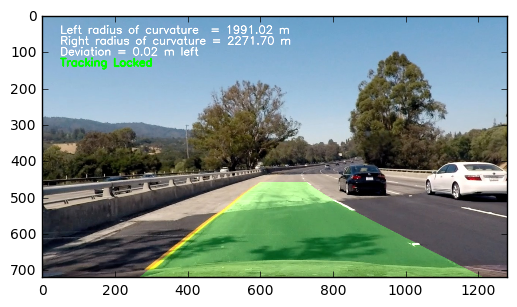

In [46]:
def process_image(image, key_frame_interval=20, cache_length=10):
    global cam_mtx, cam_dist
    
    if process_image.cache is None:
                
        left_lane = Lane(int(0.16*image.shape[0]), image.shape[:2], cache_length=cache_length)
        right_lane = Lane(int(0.62*image.shape[0]), image.shape[:2], cache_length=cache_length)

        cache = {'cam_mtx': cam_mtx,
                 'cam_dist': cam_dist,
                 'warp_m': None,
                 'warp_minv': None,
                 'frame_ctr': 0,
                 'left': left_lane,
                 'right': right_lane,
                 'base_pts': None}
    else:
        cache = process_image.cache
    

    left_lane = cache['left']
    right_lane = cache['right']

    # Preprocess image and find edges using thresholding
    undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
    
    if cache['warp_m'] is None:# or cache['frame_ctr'] % key_frame_interval == 0:
        src = find_perspective_points(undist)
        warp_m, warp_minv = get_perspective_transform(image, src_in = src)
        
        if src is not None:
            # Save only if customized perspective transform is found
            cache['warp_m'] = warp_m
            cache['warp_minv'] = warp_minv
    else:
        warp_m, warp_minv = cache['warp_m'], cache['warp_minv']
    
    warp_img = cv2.warpPerspective(undist, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    warp_edges = find_edges(warp_img)
    
    base_pts = cache['base_pts']
    if base_pts is None: #or cache['frame_ctr'] % key_frame_interval == 0:
        new_base_pts = find_base_points(warp_edges)

        if new_base_pts is not None:
            base_pts = new_base_pts
        else:
            # Could not find new base points
            # Re-use previous data if base points could not be found
            cache['frame_ctr'] = cache['frame_ctr'] - 1 # Make sure we try again in the next frame
            return undist

    if ((left_lane.current_xfit is None or left_lane.dropped_frames > 16) 
            or (right_lane.current_xfit is None or right_lane.dropped_frames > 16)):
        # Detect from scratch
        left_lane.radius_of_curvature = None
        right_lane.radius_of_curvature = None
        histogram_lane_detection(warp_edges, left_lane, right_lane, base_pts)
    else:
        left_lane.detect_from_mask(warp_edges)
        right_lane.detect_from_mask(warp_edges)

    cache['frame_ctr'] = cache['frame_ctr'] + 1
    cache['base_pts'] = base_pts
    process_image.cache = cache
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)
    
    yvals = left_lane.yvals
    left_fitx = left_lane.current_xfit
    right_fitx = right_lane.current_xfit
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, warp_minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    left_r = left_lane.radius_of_curvature
    right_r = right_lane.radius_of_curvature
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = image.shape[1]//2
    
    dx = (veh_pos - middle)*xm_per_pix # Positive if on right, Negative on left

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_r),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_r),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Deviation = %.2f m %s'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)

    is_tracking = left_lane.detected or right_lane.detected
    cv2.putText(result,'Tracking Locked' if is_tracking else 'Tracking Lost',(50,140),
            font, 1,(0,255,0) if is_tracking else (255,0,0), 3,cv2.LINE_AA)
    
    cache['left'] = left_lane
    cache['right'] = right_lane

    return result

def clear_cache():
    process_image.cache = None
    
process_image.clear_cache = clear_cache
clear_cache()
image = mpimage.imread('test_images/test4.jpg')
%time process_image(image)
# %time process_image(image)
out = process_image(image)
plt.figure()
plt.imshow(out)
plt.show()

In [47]:
vid_output = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')

In [48]:
clear_cache()
vid_clip = clip.fl_image(process_image)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:40<00:00,  1.89it/s]    | 1/1261 [00:00<05:17,  3.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 9min 10s, sys: 57.8 s, total: 10min 7s
Wall time: 8min 45s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [32]:
clear_cache()
vid_output = 'challenge_video_out.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
vid_clip = clip2.fl_image(process_image)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [02:55<00:00,  2.46it/s]     | 1/485 [00:00<02:13,  3.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 3min 11s, sys: 17.7 s, total: 3min 28s
Wall time: 2min 59s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [ ]:
clear_cache()
vid_output = 'harder_challenge_video_out.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
vid_clip = clip2.fl_image(process_image)
%time vid_clip.write_videofile(vid_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))